# Plotting Tools

In [1]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import datetime
import scipy.stats as sp 
from matplotlib import cm
from tqdm import tqdm

# Plot Armball tests 

In [2]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3
plt.rcParams.update({'font.size': 22})

# Comparison

In [3]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<5:
        ncol = [1,1,2,2,2][len(means)] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2, loc="center left",ncol=ncol,bbox_to_anchor=(0., 1.07))
    plt.show()

# My tensorflow

In [4]:
def plot_episodes_errors(subdirs,names,func,data_type):
    data = ['eval_training_data.pk','eval_evaluation_data.pk','prediction.pk'][data_type]
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    for param in subdirs:
        traj_errors = []
        trans_errors = []
        for subdir in param:
            f = open(subdir+data,'br')
            (pred_traj,pred_trans,true_traj) = pickle.load(f)
            true_traj = np.swapaxes(true_traj[:,:,:18], 0,1)
            if data_type == 2:
                pred_traj = pred_traj[:,:,:18]
                a, axis = 2, 0
            else:
                pred_traj = pred_traj[:,:,:,:18]
                a , axis = 3, (0,1)
            f.close()

            traj_errors.append(func(np.linalg.norm( pred_traj-true_traj, axis=(a)), axis=a-1))
            trans_errors.append(func(np.linalg.norm( pred_trans-true_traj, axis=(a)), axis=a-1))
        traj_means.append(np.mean(traj_errors, axis=axis))
        trans_means.append(np.mean(trans_errors, axis=axis))
        trans_stds.append(np.std(trans_errors, axis=axis))
        traj_stds.append(np.std(traj_errors, axis=axis))


    means = traj_means+trans_means
    stds = traj_stds +trans_stds
    
    names = [name+' traj' for name in names]+ [name+' trans' for name in names]
    plot_performance(means,stds,log=True,names=names,ylabel="Trajectory prediction error",xlabel="Prediction length")
    
    fig,axarr = plt.subplots(2,1, sharex=True,figsize=(16,12))

    plt.subplot(211)
    plt.title("trajectory error")
    plt.boxplot(traj_means)
    plt.yscale('log')
    plt.xticks([i for i in range(1,1+len(names)//2)],names[:len(names)//2])
    
    plt.subplot(212)
    plt.boxplot(trans_means)
    plt.title("transition error")
    plt.ylabel("Error")
    plt.yscale('log')
    
    plt.xticks([i for i in range(1,1+len(names)//2)],names[:len(names)//2])

In [5]:
def plot_pred(subdir,data_type, j, Tmax, Pmax):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    data = ['eval_training_data.pk','eval_evaluation_data.pk','prediction.pk'][data_type]
    with open(subdir+data,'br')as f:
        (pred_traj,pred_trans,true_traj) = pickle.load(f)
    if Pmax<5:
        colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    else:
        colors = np.random.random((Pmax,3))
    
    for p in range(Pmax):
        plt.plot(true_traj[j,:Tmax+1,p]-true_traj[j,0,p], c=colors[p], label=str(p))
        if data_type == 2:
            plt.plot(pred_traj[:Tmax+1,j,p]-pred_traj[0,j,p], ls=":", c=colors[p])
        else:
            for b in range(len(pred_traj)):
                plt.plot(pred_traj[b,:Tmax+1,j,p]-pred_traj[b,0,j,p], ls=":", c=colors[p])
        #plt.plot(true_traj[j,:Tmax+1,p]-pred_traj[j,:Tmax+1,p], c=colors[p], label=str(p))
    plt.legend()


In [6]:
def plot_confusion_matrix(subdirs,data):
    def analyze_confusion_matrix(conf_matrix):
        [[TN,FN],[FP,TP]] = conf_matrix
        TPR = TP/(TP+FN) if (TP +FN) !=0 else 0
        TNR = TN/(TN+FP) if (FP +TN) !=0 else 0
        ACC = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) !=0 else 0
        Precision = TP/(TP+FP) if (TP+FP) !=0 else 0
        FS = 2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) !=0 else 0
        return [TPR,TNR,ACC,Precision,FS]
    
    tasks_group =[[0,1,2,3],[4],[6,7,8,9],[14] , 
                  [5],[10,11,12,13], [15], 
                  [16] , [18,19,20,21],
                  [17], [22, 23,24,25]]

    group_legend = ['Hand', 
                    'Grasp Stick1','Move Stick1', 'Bring S1 Closer to M',   
                    'Grasp Stick2','Move Stick2', 'Bring S2 Closer to S', 
                    'Grasp Magnet', 'Move Magnet',
                    'Grasp Scratch','Move Scratch']

    rates_names = ['Recall','TNR','Accuracy','Precision','F1 Score']
    hatches = ['/','o','-','+']
    color = ['blueviolet']+['royalblue']*3+['crimson']*3+['darkgreen']*2+['orange']*2
        
    Rates = []
    Rates_error = []
    if data is None:
        for data in [0,1]:
            filename = ['confusion_matrix_training_data.pk','confusion_matrix_evaluation_data.pk',
                       'confusion_matrix.pk'][data]
            with open(subdirs[0][0]+filename,'br')as f:
                conf_matrix = pickle.load(f)
            conf_matrix = np.mean(conf_matrix, axis=0)
            rates = [[] for _ in range(5)]
            for group in tasks_group:
                res = analyze_confusion_matrix(np.mean(conf_matrix[group],axis=0))
                for i in range(5):
                    rates[i].append(res[i])
            Rates.append(rates)
    else:
        for params in subdirs:
            filename = ['confusion_matrix_training_data.pk','confusion_matrix_evaluation_data.pk',
                       'confusion_matrix.pk'][data]
            rates_mean = []
            for subdir in params:
                with open(subdir+filename,'br')as f:
                    conf_matrix = pickle.load(f)
                if data == 2:
                    conf_matrix = conf_matrix
                else:
                    conf_matrix = np.mean(conf_matrix, axis=0)
                rates = [[] for _ in range(5)]
                for group in tasks_group:
                    res = analyze_confusion_matrix(np.mean(conf_matrix[group],axis=0))
                    for i in range(5):
                        rates[i].append(res[i])
                rates_mean.append(rates)
            Rates.append(np.mean(rates_mean, axis=0))
            Rates_error.append(np.std(rates_mean, axis=0))
    for i in range(5):
        fig,axarr = plt.subplots(1,1, sharex=True,figsize=(16,9))
        plt.subplot(111)
        w = 1/len(Rates)
        width = [w]*11
        for j in range(len(Rates)):
            y = Rates[j][i]
            x = np.array(range(len(y)))+w*j
            yerr = Rates_error[j][i]
            plt.bar( x, y, width, yerr=yerr, align='edge',color=color, edgecolor='black', hatch=hatches[j])

        plt.ylim((0,1))
        plt.xticks(np.array(range(len(y))),group_legend, rotation='vertical')
        plt.title(rates_names[i])


In [7]:
def plot_errors(subdirs,names,func,data_type, iteration=None, cpu=None):
    if data_type < 3:
        file = ['eval_training_data.pk','eval_evaluation_data.pk','prediction.pk'][data_type]
    else:
        file = ['eval_evaluation_data_'+str(iteration)+'.pk',
                'prediction_r'+str(cpu)+'_'+str(iteration)+'.pk'][data_type-3]
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    for param in subdirs:
        traj_errors = []
        trans_errors = []
        for subdir in param:
            if data_type < 3:
                with open(subdir+file,'br') as f:
                    (pred_traj,pred_trans,true_traj) = pickle.load(f)
            else:
                with open(subdir+file,'br') as f:
                    (pred_traj,pred_trans) = pickle.load(f)
                with open("/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_1000pertinent.pk", 'br') as f:
                    [true_traj,_] = pickle.load(f)
            true_traj = np.swapaxes(true_traj[:,:,:18], 0,1)
            if data_type in [2,4]:
                pred_traj = pred_traj[:,:,:18]
                a, axis = 2, (0,1)
            else:
                pred_traj = pred_traj[:,:,:,:18]
                a, axis = 3, (0,1,2)
            f.close()

            traj_errors.append(np.sum((pred_traj-true_traj)**2, axis=a))
            trans_errors.append(np.sum((pred_trans-true_traj)**2, axis=a))

        traj_means.append(np.mean(traj_errors, axis=axis))
        trans_means.append(np.mean(trans_errors, axis=axis))
        trans_stds.append(np.std(trans_errors, axis=axis))
        traj_stds.append(np.std(traj_errors, axis=axis))
    print('traj: ',np.mean(traj_means) ,'trans: ', np.mean(trans_means))
    means = traj_means+trans_means
    stds = traj_stds +trans_stds
    names = [name+' traj' for name in names]+ [name+' trans' for name in names]
    plot_performance(means,stds,log=True,names=names,ylabel="trajectory prediction error",
                     xlabel="evaluation episode")
    

In [8]:
def plot_traj(subdir,j, Tmax, pred_type, eval_type, cpu=None, iteration=None):
    if eval_type < 3:
        file = ['eval_training_data.pk','eval_evaluation_data.pk','prediction.pk'][eval_type]
        with open(subdir+file,'br') as f:
            (pred_traj,pred_trans,true_traj) = pickle.load(f)
    else:
        file = ['eval_evaluation_data_'+str(iteration)+'.pk',
                'prediction_r'+str(cpu)+'_'+str(iteration)+'.pk'][eval_type-3]
        with open(subdir+file,'br') as f:
            (pred_traj,pred_trans) = pickle.load(f)
        with open("/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_1000pertinent.pk", 'br') as f:
            [true_traj,_] = pickle.load(f)
    if pred_type:
        pred = pred_traj
    else:
        pred = pred_trans
    f.close()
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
    print("t",true_traj[j,0,3:4])
    print("p", pred[0,j,3:4])
    plt.scatter(  true_traj[j,-1,3], true_traj[j,-1,4],color=colors[0],marker='X',zorder=4,s=100)
    plt.scatter(  true_traj[j,-1,8], true_traj[j,-1,9],color=colors[1],marker='X',zorder=4,s=100)   
    plt.scatter(true_traj[j,-1,12], true_traj[j,-1,13],color=colors[2],marker='X',zorder=4,s=100)   
    plt.scatter(true_traj[j,-1,14], true_traj[j,-1,15],color=colors[3],marker='X',zorder=4,s=100)   
    plt.scatter(true_traj[j,-1,16], true_traj[j,-1,17],color=colors[4],marker='X',zorder=4,s=100)   
    
    plt.plot(  true_traj[j,:Tmax,3], true_traj[j,:Tmax,4],lw=LW,ls="-",c=colors[0])
    plt.plot(  true_traj[j,:Tmax,8], true_traj[j,:Tmax,9],lw=LW,ls="-",c=colors[1])
    plt.plot(true_traj[j,:Tmax,12], true_traj[j,:Tmax,13],lw=LW,ls="-",c=colors[2])  
    plt.plot(true_traj[j,:Tmax,14], true_traj[j,:Tmax,15],lw=LW,ls="-",c=colors[3])
    plt.plot(true_traj[j,:Tmax,16], true_traj[j,:Tmax,17],lw=LW,ls="-",c=colors[4])  
    
    if eval_type in [0,1,3]:
        for b in range(len(pred)):
            plt.scatter(  pred[b,-1,j,3], pred[b,-1,j,4],color=colors[0],marker='o',zorder=4,s=100)
            plt.scatter(  pred[b,-1,j,8], pred[b,-1,j,9],color=colors[1],marker='o',zorder=4,s=100)
            plt.scatter(pred[b,-1,j,12], pred[b,-1,j,13],color=colors[2],marker='o',zorder=4,s=100)
            plt.scatter(pred[b,-1,j,14], pred[b,-1,j,15],color=colors[3],marker='o',zorder=4,s=100)
            plt.scatter(pred[b,-1,j,16], pred[b,-1,j,17],color=colors[4],marker='o',zorder=4,s=100)
            if b==0:
                plt.plot(  pred[b,:Tmax,j,3], pred[b,:Tmax,j,4],lw=LW,ls=":",zorder=3,c=colors[0],label="hand")
                plt.plot(  pred[b,:Tmax,j,8], pred[b,:Tmax,j,9],lw=LW,ls=":",zorder=3,c=colors[1],label="stick1")
                plt.plot(pred[b,:Tmax,j,12], pred[b,:Tmax,j,13],lw=LW,ls=":",zorder=3,c=colors[2],label="stick2")
                plt.plot(pred[b,:Tmax,j,14], pred[b,:Tmax,j,15],lw=LW,ls=":",zorder=3,c=colors[3],label="magnet")
                plt.plot(pred[b,:Tmax,j,16], pred[b,:Tmax,j,17],lw=LW,ls=":",zorder=3,c=colors[4],label="scratch")
            else:
                plt.plot(  pred[b,:Tmax,j,3], pred[b,:Tmax,j,4],lw=LW,ls=":",zorder=3,c=colors[0])
                plt.plot(  pred[b,:Tmax,j,8], pred[b,:Tmax,j,9],lw=LW,ls=":",zorder=3,c=colors[1])
                plt.plot(pred[b,:Tmax,j,12], pred[b,:Tmax,j,13],lw=LW,ls=":",zorder=3,c=colors[2])
                plt.plot(pred[b,:Tmax,j,14], pred[b,:Tmax,j,15],lw=LW,ls=":",zorder=3,c=colors[3])
                plt.plot(pred[b,:Tmax,j,16], pred[b,:Tmax,j,17],lw=LW,ls=":",zorder=3,c=colors[4])

    else:
        plt.scatter(  pred[-1,j,3], pred[-1,j,4],color=colors[0],marker='o',zorder=4,s=100)
        plt.scatter(  pred[-1,j,8], pred[-1,j,9],color=colors[1],marker='o',zorder=4,s=100)
        plt.scatter(pred[-1,j,12], pred[-1,j,13],color=colors[2],marker='o',zorder=4,s=100)
        plt.scatter(pred[-1,j,14], pred[-1,j,15],color=colors[3],marker='o',zorder=4,s=100)
        plt.scatter(pred[-1,j,16], pred[-1,j,17],color=colors[4],marker='o',zorder=4,s=100)

        plt.plot(  pred[:Tmax,j,3], pred[:Tmax,j,4],lw=LW,ls=":",zorder=3,c=colors[0],label="hand")
        plt.plot(  pred[:Tmax,j,8], pred[:Tmax,j,9],lw=LW,ls=":",zorder=3,c=colors[1],label="stick1")
        plt.plot(pred[:Tmax,j,12], pred[:Tmax,j,13],lw=LW,ls=":",zorder=3,c=colors[2],label="stick2")
        plt.plot(pred[:Tmax,j,14], pred[:Tmax,j,15],lw=LW,ls=":",zorder=3,c=colors[3],label="magnet")
        plt.plot(pred[:Tmax,j,16], pred[:Tmax,j,17],lw=LW,ls=":",zorder=3,c=colors[4],label="scratch")       
    
    plt.legend()

In [206]:
#ALL
train_400_E50 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-06 15:12:33.403191/"
train_400_E20 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-06 15:09:46.871224/"
train_400_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 11:03:06.589897/"
train_400_E5x10_2 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 13:27:15.965663/"
train_400_E5x10_3 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 13:30:17.948567/"

rand_400_E5x10_1 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:04:06.773485/"
rand_400_E5x10_2 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:05:01.690039/"
rand_400_E5x10_3 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:06:20.198979/"
rand_400_E5x10_4 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:07:14.011656/"
rand_400_E5x10_5 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:08:22.181526/"

rand2_400_E5x10_1 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:42:04.778127/"
rand2_400_E5x10_2 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:43:39.408587/"
rand2_400_E5x10_3 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:46:09.738973/"
rand2_400_E5x10_4 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:47:45.564240/"
rand2_400_E5x10_5 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:49:30.820393/"

train_4000_E50 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 09:33:33.272141/"
train_4000_E20 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-06 15:03:15.260011/"

train_4000_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 09:24:39.611758/"
train_4000_E5x10_2 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 13:37:32.224467/"
train_4000_E5x10_3 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 13:47:11.696824/"

train_4000_E5x10_REG_1_m3 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 10:36:38.996937/"
train_4000_E5x10_REG_5_m4 ="/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 10:47:33.282024/"

rand_4000_E5x10_1 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:09:28.860552/"
rand_4000_E5x10_2 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:15:56.594515/"
rand_4000_E5x10_3 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:22:04.458726/"
rand_4000_E5x10_4 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:28:54.202069/"
rand_4000_E5x10_5 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 14:35:24.063638/"


train_40000_E20 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-06 15:47:33.065533/"
train_40000_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 09:47:06.154205/"

# hand + stick1
HS1_400_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 11:16:01.775385/"
HS1_4000_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 11:20:22.952136/"

# hand + stick1 + magnet
HS1M_4000_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 11:36:13.187451/"
HS1M_40000_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 11:52:35.596815/"

# hand + s2 + scratch
HS2S_400_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 13:25:37.143043/"
HS2S_4000_E5x10 = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-07 13:12:20.784864/"

unicorn_20 = "/home/tim/Documents/stage-m2/multi-task-her-rl/src/data/from_remote/ATT_20cpu_0/"
random = "/home/tim/Documents/stage-m2/tf_test/log/random_0/"

test = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/rl_0/"
imgep = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/imgep_0/"

""" Groups """
rand_4000_from_40000 = [rand_4000_E5x10_1,rand_4000_E5x10_2,rand_4000_E5x10_3,rand_4000_E5x10_4,rand_4000_E5x10_5 ]
rand_400_from_4000 = [rand_400_E5x10_1,rand_400_E5x10_2,rand_400_E5x10_3,rand_400_E5x10_4,rand_400_E5x10_5 ]
rand_400_from_40000 = [rand2_400_E5x10_1,rand2_400_E5x10_2,rand2_400_E5x10_3,rand2_400_E5x10_4,rand2_400_E5x10_5]
subdirs = [ 
            rand_400_from_4000,
            rand_4000_from_40000
            ]


subdirs = [[test],[imgep]]
names = ["400","imgep"]

In [9]:
path = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/"
# Random
random = [0,1,2,3,4,5,6,7,8,9]
# GRBF
grbf = [0,1,2,3,4,5,6,7,8,9]
#IMGEP
imgep = [0,1,2,3,4,5,6,7,8,9]
#EXPLO
explo = [0,1,2,3,4,5,6,7,8,9]
# Model_Free
model_free = [0]
# RL
rl = [0,1,2,3,4,6,7,8,9]

subdirs =[[path+"random_"+str(i) for i in random],
          [path+"grbf_"+str(i) for i in grbf],
          [path+"imgep_"+str(i) for i in imgep],
          [path+"explo_"+str(i) for i in explo],
          [path+"rl_"+str(i) for i in rl]
          ]


perf_subdirs=[[path+"random_"+str(i) for i in random],
              [path+"grbf_"+str(i) for i in [0,1,2,3,4,5,6,7,8]],
              [path+"imgep_"+str(i) for i in imgep],
              [path+"explo_"+str(i) for i in explo],
              [path+"rl_"+str(i) for i in rl],
              [path+"model-free_"+str(i) for i in [0]]
              ]

data_type = 1
cpus = 20
names = ['Random', 'GRBF', 'IMGEP', "EU", "//RL", "MFRL"]
iterations = 10

In [10]:
plot_errors(subdirs[0],names,np.mean,data_type=4, cpu=19, iteration=9)

FileNotFoundError: [Errno 2] No such file or directory: '/prediction_r19_9.pk'

t [6.123234e-17]
p [-0.06415749]


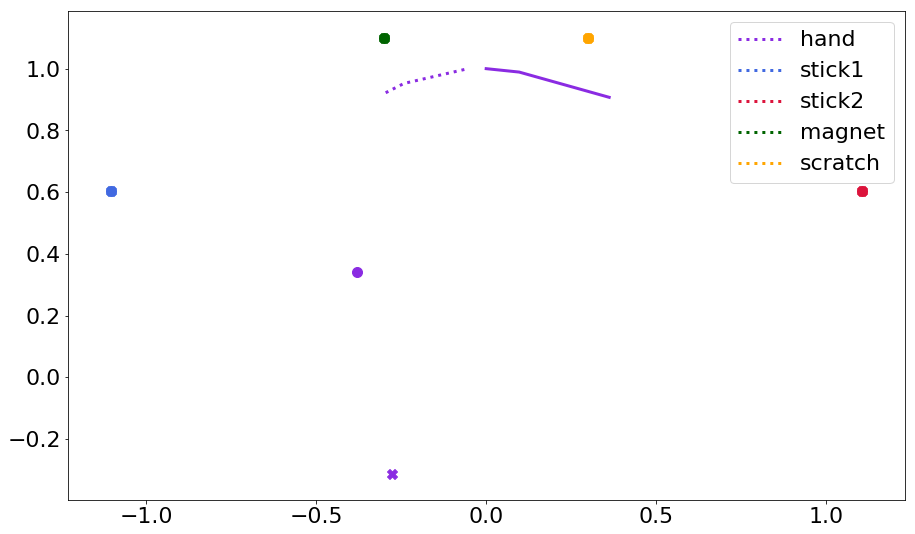

In [212]:
# 3 stick2, 4 scratch
# 504 stick1, 515 magnet
plot_traj(subdirs[1][0],j=0,Tmax=3,pred_type=1, eval_type=4, iteration=9, cpu=3)

In [201]:
plot_confusion_matrix(subdirs,2)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/rl_0/confusion_matrix.pk'

In [ ]:
plot_episodes_errors(subdirs,names,np.mean,2)

In [ ]:
plot_pred(subdirs[0][0],data_type=2, j=0, Tmax=51, Pmax=4)

# Exploration

In [9]:
GRBF = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-09 13:55:06.838349"
uniform = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-09 14:05:10.620229"

increasing_horizon = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-10 15:12:30.592432"
fixed_horizon = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-13 13:59:45.939339"

subdir = fixed_horizon

data = []
with open(subdir+"/exploration.pk", "rb") as f:
    while True:
        try:
            data.append(pickle.load(f))
        except:
            break



In [10]:
[actions, uncertainty, obs, pred] = data[-1]
obs = np.array(obs) 

moving = []
fixed = []
for j in range(len(uncertainty)):
    if np.linalg.norm(obs[j,-1,24:36]) > 0 :
        moving.append(j)
    else:
        fixed.append(j)
print(len(moving),len(fixed))

from scipy.stats import ttest_ind,  shapiro, mannwhitneyu
data1 = uncertainty[moving]
data2 = uncertainty[fixed]

W, p1 = shapiro(data1)
W, p2= shapiro(data2)
print("shaprior:", p1, p2)
stat, p = ttest_ind(data1,data2 )
print("ttest:", stat, p)
stat, p = mannwhitneyu(data1, data2)
print("man whitney u:", stat, p)

94 406
shaprior: 8.425237590925505e-11 3.7025324195878685e-16
ttest: 1.500291333531184 0.13417265044932208
man whitney u: 17110.0 0.05916070050769322


In [ ]:
[actions, uncertainty, obs, pred] = data[1]
obs = np.array(obs) 

uncertainty = np.sum(np.std(pred, axis=0), axis=(0,2))

cmap = cm.get_cmap('jet')
norm = plt.Normalize(vmin=min(uncertainty), vmax=max(uncertainty))

fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,12))
for j in range(0,len(uncertainty)):
    plt.plot(obs[j,:,3], obs[j,:,4],lw=3,alpha=0.5, c=cmap(norm(uncertainty[j])))
    
plt.title("Hand Trajectories Uncertainty")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm)
cb.ax.set_ylabel('Uncertainty')

In [ ]:
cmap = cm.get_cmap('jet')
norm = plt.Normalize(vmin=min(uncertainty), vmax=max(uncertainty))

fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))
for j in range(0,len(uncertainty)):
    plt.plot(obs[j,:,8], obs[j,:,9],ls="--",lw=3,alpha=0.5, c=cmap(norm(uncertainty[j])))
    plt.plot(obs[j,:,12], obs[j,:,13], ls= ":", lw=3,alpha=0.5, c=cmap(norm(uncertainty[j])))

plt.title("Sticks Trajectories Uncertainty")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm)
cb.ax.set_ylabel('Uncertainty')

In [ ]:
cmap = cm.get_cmap('jet')
norm = plt.Normalize(vmin=min(uncertainty), vmax=max(uncertainty))

colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
    
fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))
for j in range(450, len(uncertainty)-1):
    plt.plot(obs[j,:,8], obs[j,:,9],ls="--",lw=3,alpha=0.5, c=cmap(norm(uncertainty[j])))
    plt.plot(obs[j,:,12], obs[j,:,13], ls= ":", lw=3,alpha=0.5, c=cmap(norm(uncertainty[j])))
    for i in range(5):
        plt.plot(pred[i,:,j,8],pred[i,:,j,9], c=colors[i] )
        plt.plot(pred[i,:,j,12],pred[i,:,j,13], c=colors[i] )
        
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
plt.colorbar(sm)

In [ ]:
i = 1
[actions, uncertainty, obs, pred] = data[i]
EU = np.std(pred, axis=0)[:,:,:18]

In [ ]:
i = 1
[actions, uncertainty, obs, pred] = data[i]
obs = np.array(obs)

ep_moving = []
ep_fixed = []

tr_moving = []
tr_fixed = []

EU = np.std(pred, axis=0)[:,:,:18]

norm = np.mean(EU, axis=1)
for t in range(len(norm)):
    for d in range(len(norm[t])):
        if norm[t][d] == 0:
            norm[t][d] = 1
            
for j in range(len(uncertainty)):
    if np.linalg.norm(obs[j,-1,24:36]) > 0 :
        ep_moving.append(EU[:,j,:18]/norm)
    else:
        ep_fixed.append(EU[:,j,:18]/norm)
    for t in range(1,len(obs[j])):
        if np.linalg.norm(obs[j,t,6:18]-obs[j,t-1,6:18]) > 0 :
            tr_moving.append(EU[t,j,:18]/norm[t])
        else:
            tr_fixed.append(EU[t,j,:18]/norm[t])

print(len(ep_moving),len(ep_fixed))
print(len(tr_moving),len(tr_fixed))

data1 = np.mean(ep_moving, axis=(1,2))
data2 = np.mean(ep_fixed, axis=(1,2))
print(np.mean(data1),np.mean(data2))
W, p1 = shapiro(data1)
W, p2= shapiro(data2)
print("shaprior:", p1, p2)
stat, p = ttest_ind(data1,data2 )
print("ttest:",  p)
stat, p = mannwhitneyu(data1, data2)
print("man whitney u:",  p)

fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))

x1 = np.array(range(5))
x2 = x1 +0.5
width = [0.5]*5

y1 = np.mean(ep_moving,axis=(0,1))
y2 = np.mean(ep_fixed,axis=(0,1))

#y1 = np.mean(tr_moving,axis=(0))
#y2 = np.mean(tr_fixed,axis=(0))

y1 = [np.mean(y1[:6]), np.mean(y1[6:10]), np.mean(y1[10:14]),np.mean(y1[14:16]),np.mean(y1[16:18])]
y2 = [np.mean(y2[:6]), np.mean(y2[6:10]), np.mean(y2[10:14]),np.mean(y2[14:16]),np.mean(y2[16:18])]

plt.bar(x1,y1,width,label="moving", )
plt.bar(x2,y2,width,label="static")

plt.title("Estimated epistemic uncertainty")
group_legend = ["Hand", "Stick1", "Stick2", "Magnet", "Scratch"]
plt.xticks(np.array(range(len(y1)))+0.25,group_legend, rotation='vertical')
plt.legend()

In [ ]:
func = np.mean

EP_mean, TR_mean, TR_final_mean, EP_max_mean = [], [], [], []
EP_std, TR_std, TR_final_std = [], [], []

EP_mean2, TR_mean2, TR_final_mean2, EP_max_mean2 = [], [], [], []
EP_std2, TR_std2, TR_final_std2 = [], [], []


            
for i in range(1,len(data)):
    [_, _, obs, pred] = data[i]
    obs = np.array(obs)
    EU = np.std(pred, axis=0)[:,:,:18]
    norm = np.mean(EU, axis=1)
    for t in range(len(norm)):
        for d in range(len(norm[t])):
            if norm[t][d] == 0:
                norm[t][d] = 1
    ep, tr_final, tr , ep_max = [[],[]], [[],[]], [[],[]], [[],[]]

    for j in range(len(uncertainty)):
        if np.linalg.norm(obs[j,-1,24:36]) > 0 :
            ep[0].append(func(EU[:,j,:18]/norm))
            tr_final[0].append(func(EU[-1,j,:18]/norm[-1]))
            ep_max[0].append(np.max(np.mean(EU[:,j,:18]/norm, axis=1)))
        else:
            ep[1].append(func(EU[:,j,:18]/norm))
            tr_final[1].append(func(EU[-1,j,:18]/norm[-1]))
            ep_max[1].append(np.max(np.mean(EU[:,j,:18]/norm, axis=1))) 

        for t in range(1,len(obs[j])):
            if np.linalg.norm(obs[j,t,6:18]-obs[j,t-1,6:18]) > 0 :
                tr[0].append(func(EU[t,j,:18]/norm[t]))
            else:
                tr[1].append(func(EU[t,j,:18]/norm[t]))

    EP_mean.append(np.mean(ep[0]))
    EP_std.append(np.std(ep[0]))

    TR_mean.append(np.mean(tr[0]))
    TR_std.append(np.std(tr[0]))
    
    TR_final_mean.append(np.mean(tr_final[0]))
    TR_final_std.append(np.std(tr_final[0]))    

    EP_max_mean.append(np.mean(ep_max[0]))
    EP_max_mean2.append(np.mean(ep_max[1]))
    
    EP_mean2.append(np.mean(ep[1]))
    EP_std2.append(np.std(ep[1]))

    TR_mean2.append(np.mean(tr[1]))
    TR_std2.append(np.std(tr[1]))
    
    TR_final_mean2.append(np.mean(tr_final[1]))
    TR_final_std2.append(np.std(tr_final[1])) 
    
names = ["EP","TR","TR_final"]*2

EP = (np.array(EP_mean)-np.array(EP_mean2))/np.array(EP_mean2)
TR = (np.array(TR_mean)-np.array(TR_mean2))/np.array(TR_mean2)
TR_final = (np.array(TR_final_mean)-np.array(TR_final_mean2))/np.array(TR_final_mean2)
EP_max = (np.array(EP_max_mean)-np.array(EP_max_mean2))/np.array(EP_max_mean2)

fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))
plt.plot(range(1,10),EP, lw=5, label="Episodes")
plt.plot(range(1,10),TR, lw=5, label="Transitions")
plt.plot(range(1,10),TR_final, lw=5, label="Finales Transitions")
plt.plot(range(1,10),EP_max, lw=5, label="Episodes max")
plt.ylabel("Discrimination")
plt.xlabel("Iterations")
plt.title("Estimated epistemic uncertainty discrimination")
plt.legend()


In [ ]:
Proportion = []
for it in range(10):
    print(it)
    [_, _, obs, pred] = data[it]
    obs = np.array(obs)
    EU = np.std(pred, axis=0)[:,:,:18]
    norm = np.ones((51,18))
    norm = np.mean(EU, axis=1)
    for t in range(len(norm)):
        for d in range(len(norm[t])):
            if norm[t][d] == 0:
                norm[t][d] = 1
    
    EU = np.mean(np.swapaxes(EU,0,1)/norm, axis=(1,2))
    indexes = np.argsort(EU)
    EU = EU[indexes]
    obs = obs[indexes]


    moving_x, moving_y, fixed_x, fixed_y = [], [], [], []

    for j in range(len(obs)):
        if np.linalg.norm(obs[j,-1,24:36]) > 0 :
            moving_x.append(j)
            moving_y.append(EU[j])
        else:
            fixed_x.append(j)
            fixed_y.append(EU[j])

    width = 0.75
    if False:
        fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))
        plt.boxplot([moving_x,fixed_x ])
        plt.ylabel("Uncertainty")
        plt.xlabel("Steps")
        plt.title("Estimated epistemic uncertainty discrimination")

    data1 = moving_x
    data2 = fixed_x
    print(np.mean(data1),np.mean(data2))
    W, p1 = shapiro(data1)
    W, p2= shapiro(data2)
    print("shaprior:", p1, p2)
    stat, p = ttest_ind(data1,data2 )
    print("ttest:",  p)
    stat, p = mannwhitneyu(data1, data2)
    print("man whitney u:",  p)

    proportion = []
    count = 0
    for i in range(499,-1,-1):
        if i in moving_x:
            count += 1
        proportion.append(count/(500-i))
    Proportion.append(proportion)

fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))
plt.plot(np.mean(Proportion,axis=0)[:100])

plot_performance([np.mean(Proportion,axis=0)[:100]], [np.std(Proportion,axis=0)[:100]], minimum= 0.2, maximum = 0.4)

In [ ]:
a = np.array([1,5,3,6,2,4])
ind = np.argsort(a)
a[ind[-3:]]

# Select training samples

In [50]:
import sys
sys.path.append('../multi-task-her-rl/src/reward_function/')
from reward_function import OracleRewardFuntion
oracle = OracleRewardFuntion(30)

In [142]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/imgep_eval.pk"

with open(filename, 'br') as f:
    [true_traj,Acs] = pickle.load(f)
true_traj = np.array(true_traj)
Acs = np.array(Acs)
np.shape(true_traj)

(100000, 51, 36)

In [143]:
rewards = oracle.eval_all_goals_from_state(true_traj[:,-1])+np.ones(30)
np.sum(rewards,axis=0)

array([3.2337e+04, 2.4859e+04, 0.0000e+00, 9.1284e+04, 1.8402e+04,
       3.6738e+04, 1.3252e+04, 8.0000e+01, 3.0590e+03, 1.1575e+04,
       3.2700e+02, 2.7703e+04, 5.8580e+03, 2.1163e+04, 4.4180e+03,
       1.6469e+04, 3.4100e+03, 1.4778e+04, 2.0740e+03, 3.7500e+02,
       1.4300e+02, 2.5680e+03, 4.9320e+03, 6.5370e+03, 7.0000e+01,
       1.1082e+04, 5.6320e+03, 1.8432e+04, 3.5470e+03, 1.5105e+04])

In [146]:
indices = []
count = [0 for _ in range(30)]
for j in range(len(rewards)-1,0,-1):
    to_take = False
    r_idx = np.where( rewards[j] == 1)[0]
    
    if len(r_idx) == 0:
        to_take = False

    for r in r_idx:
        if r in range(18,26) and count[r] < 50:
            to_take = True
        elif r not in range(18,26) and count[r] < 30:
            to_take = True
    if to_take:
        indices.append(j)
        for r in np.where( rewards[j] == 1)[0]:
            count[r] += 1  
count

[154,
 182,
 0,
 459,
 250,
 249,
 169,
 30,
 89,
 122,
 30,
 163,
 88,
 119,
 177,
 178,
 168,
 173,
 59,
 51,
 50,
 100,
 63,
 83,
 50,
 99,
 184,
 183,
 168,
 174]

In [149]:
indices = list(set(indices))
len(indices)

500

In [148]:
indices = indices[:-19]

In [58]:
np.sum(oracle.eval_all_goals_from_state(true_traj[indices,-1])+np.ones(30), axis=0)

array([193., 136.,   0., 438., 216., 252., 143.,  30.,  68., 107.,  30.,
       172.,  98.,  75., 114., 157.,  93., 128.,  36.,  30.,  30.,  47.,
        38.,  65.,  30.,  56., 136., 171.,  96., 135.])

In [165]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_500imgep.pk"
with open(filename, 'br') as f:
    [true_traj3,Acs3] = pickle.load(f)
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_400random.pk"
with open(filename, 'br') as f:
    [true_traj2,Acs2] = pickle.load(f)
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_100randomMS.pk"
with open(filename, 'br') as f:
    [true_traj1,Acs1] = pickle.load(f)

In [166]:
true_traj = np.concatenate((true_traj1,true_traj2,true_traj3))
Acs = np.concatenate((Acs1, Acs2,Acs3))

In [167]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_pertinent.pk"
with open(filename, 'bw') as f:
    pickle.dump([true_traj, Acs], f)

## coverage

In [168]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_pertinent.pk"

with open(filename, 'br') as f:
    [observations,acs] = pickle.load(f)
true_traj = np.array( observations)
np.shape( true_traj)

(1000, 51, 36)

In [140]:
true_traj[:,0,:3]

array([[ 0.01691469,  0.01957383, -0.03125831],
       [-0.0580488 ,  0.02031312, -0.05148962],
       [-0.03235833,  0.0484606 , -0.07369694],
       ...,
       [ 0.01240296,  0.05391701,  0.12723158],
       [-0.00059191, -0.01115582,  0.03684487],
       [ 0.05230366, -0.08799021,  0.02360851]])

Text(0.5, 1.0, 'Evaluation coverage')

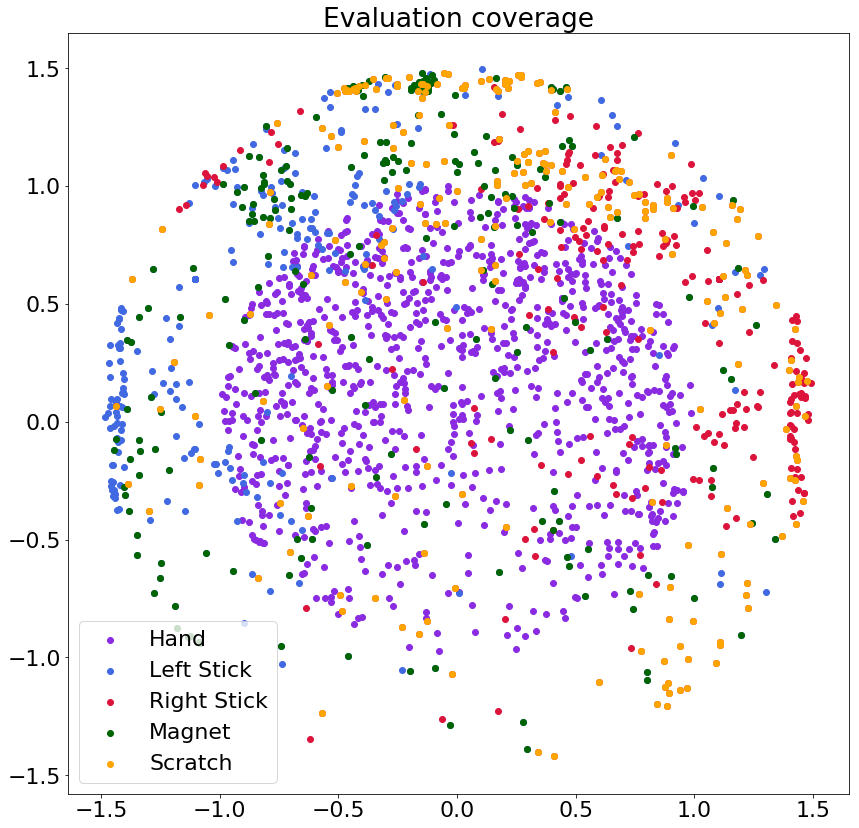

In [155]:
fig,ax = plt.subplots(1,1, sharex=True,figsize=(14,14))
colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
plt.scatter(true_traj[:,-1,3],true_traj[:,-1,4], c=colors[0], label = "Hand")
plt.scatter(true_traj[:,-1,8],true_traj[:,-1,9], c=colors[1], label = "Left Stick")
plt.scatter(true_traj[:,-1,12],true_traj[:,-1,13], c=colors[2], label = "Right Stick")
plt.scatter(true_traj[:,-1,14],true_traj[:,-1,15], c=colors[3], label = "Magnet")
plt.scatter(true_traj[:,-1,16],true_traj[:,-1,17], c=colors[4], label = "Scratch")
plt.legend()
plt.title("Evaluation coverage")

In [156]:

n_bins = [20,20]
N_bins = n_bins[0]*n_bins[1]

x , y, rng = true_traj[:,-1,3],true_traj[:,-1,4], [[-1., 1.], [-1., 1.]]
bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=rng).binnumber
hand = len(set(bins))/N_bins 

x , y, rng = true_traj[:,-1,8],true_traj[:,-1,9], [[-1.5, 1.5], [-1.5, 1.5]]
bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=rng).binnumber
lstick = len(set(bins))/N_bins 

x , y, rng = true_traj[:,-1,12],true_traj[:,-1,13], [[-1.5, 1.5], [-1.5, 1.5]]
bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=rng).binnumber
rstick = len(set(bins))/N_bins 

x , y, rng = true_traj[:,-1,14],true_traj[:,-1,15], [[-1.5, 1.5], [-1.5, 1.5]]
bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=rng).binnumber
magnet = len(set(bins))/N_bins 

x , y, rng = true_traj[:,-1,16],true_traj[:,-1,17], [[-1.5, 1.5], [-1.5, 1.5]]
bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=rng).binnumber
scratch = len(set(bins))/N_bins 

print(hand, lstick, rstick, magnet, scratch)

0.73 0.425 0.445 0.3025 0.3125


In [ ]:
0.74 0.285 0.315 0.15 0.2

# Truc

In [3]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/imgep_train9.pk"

with open(filename, 'br') as f:
    [true_traj,Acs] = pickle.load(f)
true_traj = np.array( true_traj)
Acs = np.array(Acs)

In [4]:
for it in tqdm(range(10)):
    with open('/home/tim/Documents/stage-m2/armtolstoy/arm_run_saves/imgep9/imgep_'+str(it)+'.pk', 'wb') as f:
        pickle.dump( [true_traj[it*10000:(it+1)*10000], Acs[it*10000:(it+1)*10000]], f)

100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


In [159]:
len(true_traj)

1000

In [24]:
obs

array([[0.94596538, 0.66746342],
       [0.86659299, 0.6783412 ],
       [0.79792586, 0.6013423 ],
       [0.55281277, 0.27453089],
       [0.6022745 , 0.60531597],
       [0.56334991, 0.65895227],
       [0.85242295, 0.85673756],
       [0.48288469, 0.750608  ],
       [0.82514434, 0.62980999],
       [0.81562832, 0.85032862]])

In [25]:
indexes = np.array(range(10))
np.random.shuffle(indexes)

In [26]:
indexes

array([8, 6, 9, 4, 1, 5, 0, 3, 7, 2])

In [27]:
ind = np.split(indexes, 2)

In [28]:
obs[ind[0]]

array([[0.82514434, 0.62980999],
       [0.85242295, 0.85673756],
       [0.81562832, 0.85032862],
       [0.6022745 , 0.60531597],
       [0.86659299, 0.6783412 ]])

In [29]:
obs[ind[1]]

array([[0.56334991, 0.65895227],
       [0.94596538, 0.66746342],
       [0.55281277, 0.27453089],
       [0.48288469, 0.750608  ],
       [0.79792586, 0.6013423 ]])